In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd

# Simulação 1

## Funções Acessórias

In [2]:
def plot(x, title):
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.plot(x)
    plt.show()

In [3]:
def calcular_numero_de_zeros(vetor):
    return int(2**np.ceil(np.log2(len(vetor))) - len(vetor))

In [4]:
def complete_zeros(n, vector):
    return np.concatenate([vector, np.zeros(n)])

In [5]:
def get_fft_index(i, width):
    i_fft = '{:0{width}b}'.format(i, width=width)
    return int(i_fft[::-1], 2)

In [6]:
def org_index_fft(size_fft):
    org_index_fft = []
    for i in np.arange(0,size_fft):
        numbits = int(np.ceil(np.log2(size_fft)))
        org_index_fft.append(get_fft_index(i,numbits))
    return org_index_fft

In [7]:
def wN(N, signal):
    return np.exp(signal*1j*2*np.pi/N)

## Criação da FFT

In [8]:
def fft(fact,N, vec=[]):    
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]

    if size_v == 1:
        g = vec[0] + vec[1]
        h = vec[0] - vec[1]
        return np.array([g,h])
    else:   
        wNs_tam = size_v
        Wns = wN(N, -1)**[(fact*i) for i in np.arange(0,wNs_tam)]
        
        g = p1 + p2
        h = (p1 - p2)*Wns
        
        fact = fact*2
        
        g = fft(fact, N, g)
        h = fft(fact, N, h)
    fft_ = np.concatenate([g,h])
    if fact == 2:
        fft_ = fft_[org_index_fft(len(fft_))]
    return fft_

## Criação da IFFT

In [9]:
def inverse_fft(fact,N, vec):
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]

    if size_v == 1:
        g = vec[0] + vec[1]
        h = vec[0] - vec[1]
        return np.array([g,h])
    else:   
        wNs_tam = size_v
        Wns = wN(N, 1)**[(fact*i) for i in np.arange(0,wNs_tam)]
        
        g = p1 + p2
        h = (p1 - p2)*Wns
        
        fact = fact*2
        
        g =inverse_fft(fact, N, g)
        h = inverse_fft(fact, N, h)
    
    fft_ = np.concatenate([g,h])
    if fact == 2:
        fft_ = (fft_[org_index_fft(len(fft_))])/N
    return fft_
    

## Criação do método Sobreposição e soma (Over and Add)

In [10]:
def overlap_add(N, x , h ):
    M = int(len(h))
    No = N - M + 1
    num_blocks_x = int(len(x))//No
    y = np.zeros(int(len(x)) + M-1, dtype='complex')
    
    not_div_flag = False

    if(len(x) % N != 0):
        not_div_flag = True
    
    h = complete_zeros((N-M),h)
    h_jw = fft(1, N, h)
    
    for i in np.arange(0,num_blocks_x):
        x_block = x[i*(No):(i+1)*No]
        x_block = complete_zeros(M-1, x_block)
        
        if(i == (num_blocks_x -1) and not_div_flag):
            num_zeros_add = N-len(x_block)
            x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
            
        x_block_jw = fft(1, N, x_block)
        conv_temp = inverse_fft(1, N, h_jw*x_block_jw)
        y[i*No: (i*No + N)] += conv_temp 
    return y

## Criação do método Sobreposição e armazenamento (Over and Save)

In [11]:
def overlap_save(N, x, h):
    M = int(len(h))
    L = N - M + 1
    tam_x_in = L - (M-1) 

    number_blocks_x = int(np.ceil(len(x)/L))
    y = np.zeros(0, dtype='complex')
    h = complete_zeros((N-M),h)
    not_div_flag = False

    if(len(x) % N != 0):
        not_div_flag = True
        
    x_block = np.concatenate([np.zeros(M-1), x[0: L]])
    
    conv_freq = fft(1, N,x_block)* fft(1, N, h)
    conv_temp = inverse_fft(1, N, conv_freq)
    
    y = np.concatenate([y,conv_temp[(M-1):]])
    for j in np.arange(1, number_blocks_x):
        x_block = x[j*L - (M-1) : ((j+1)*L)]
        
        if(j == (number_blocks_x -1) and not_div_flag):
            num_zeros_add = N-len(x_block)
            x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
            
        h_jw = fft(1, N, h)
        x_block_jw = fft(1, N, x_block)
      
        conv_temp = inverse_fft(1, N, h_jw*x_block_jw)

        y = np.concatenate([y,conv_temp[(M-1):]])
    return y
    

## Criação e plots do sinal tipo porta de 3000 pontos e de 220 pontos

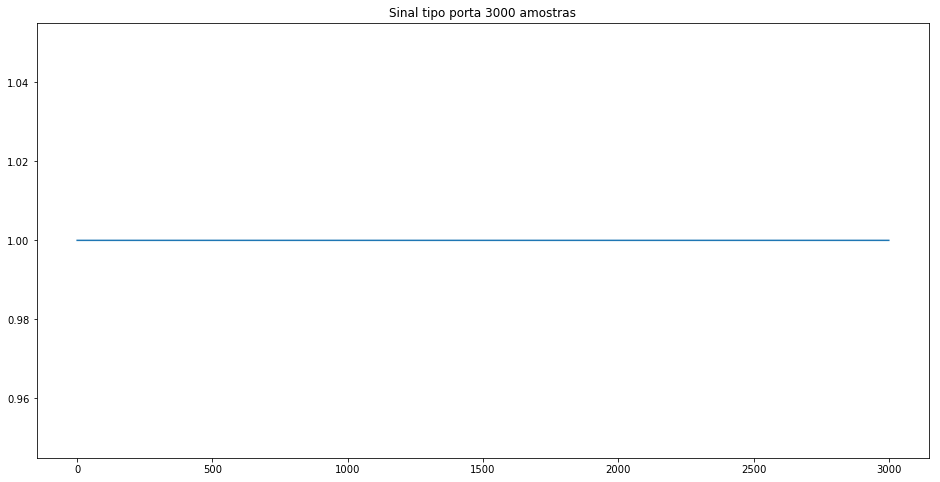

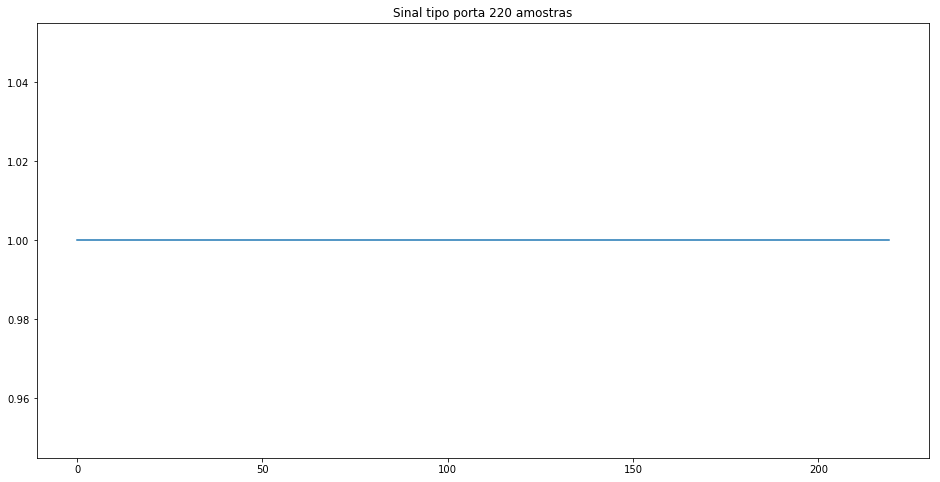

In [12]:
signal_port_3000 = np.ones(3000)
signal_port_220 = np.ones(220)

plot(signal_port_3000, "Sinal tipo porta 3000 amostras")
plot(signal_port_220, "Sinal tipo porta 220 amostras")

## Gráfico da convolução utilizando o método Sobreposição e soma

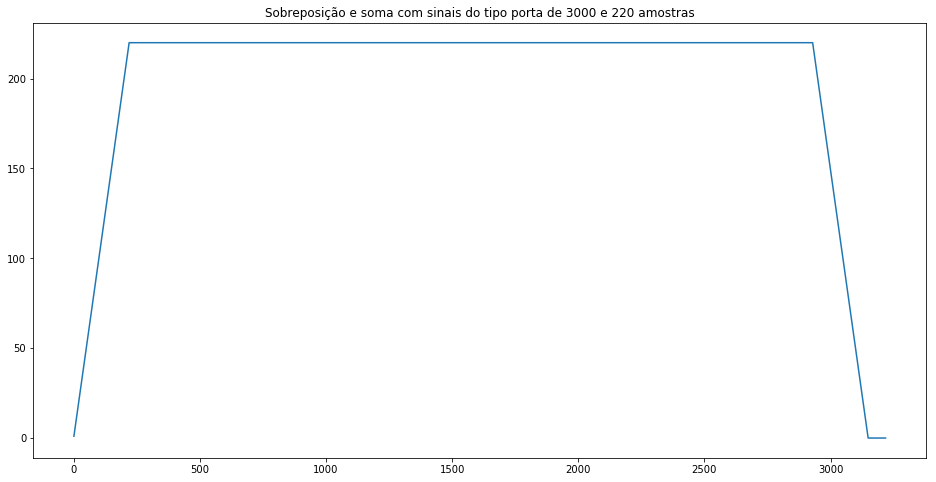

In [13]:
over_and_add = overlap_add(512, signal_port_3000, signal_port_220)

plot(np.absolute(over_and_add), "Sobreposição e soma com sinais do tipo porta de 3000 e 220 amostras")

## Gráfico da convolução utilizando o método Sobreposição e armazenamento

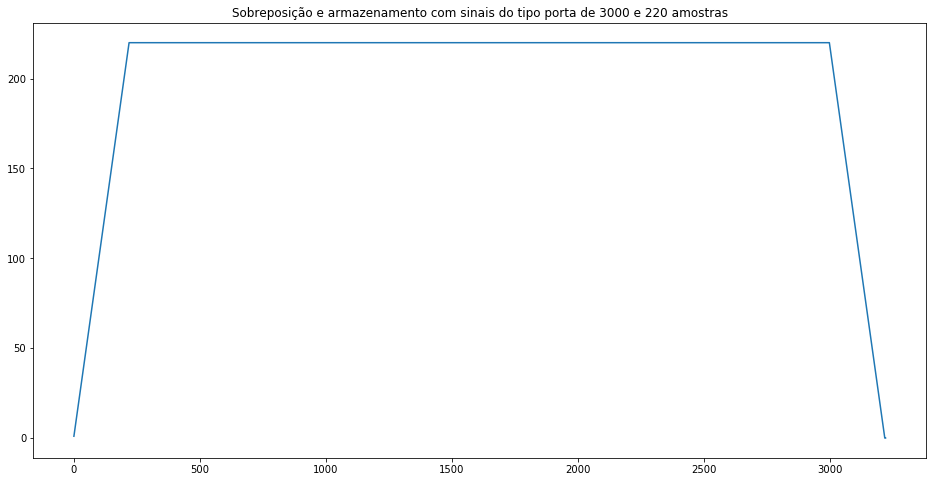

In [14]:
over_and_save = overlap_save(512, signal_port_3000, signal_port_220)

plot(np.absolute(over_and_save), 
     "Sobreposição e armazenamento com sinais do tipo porta de 3000 e 220 amostras")

## Convolução utilizando a função 'convolve' do numpy (Python)

In [15]:
np_conv = np.convolve(signal_port_3000, signal_port_220)

## Gráficos da convolução original do python

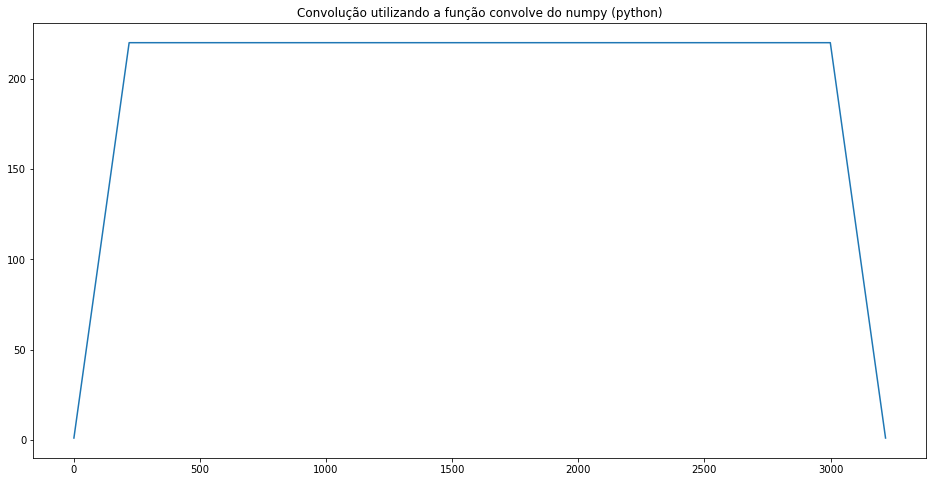

In [16]:
plot(np.absolute(np_conv), 'Convolução utilizando a função convolve do numpy (python)')

# Simulação 2

## Criação do filtro, h[n]

In [17]:
n = np.arange(0,125)
h = ((np.sinc(0.325*(n - 62)))*(0.325))* (0.5 - 0.5*np.cos(2*np.pi*n/124))

## Plot de h[n]

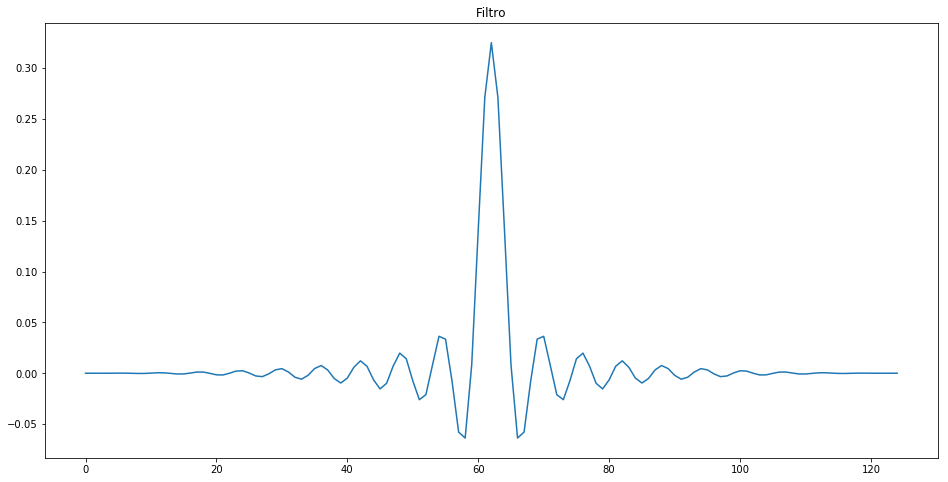

In [30]:
plot(h, "Filtro")

## Plot da fft de h[n]

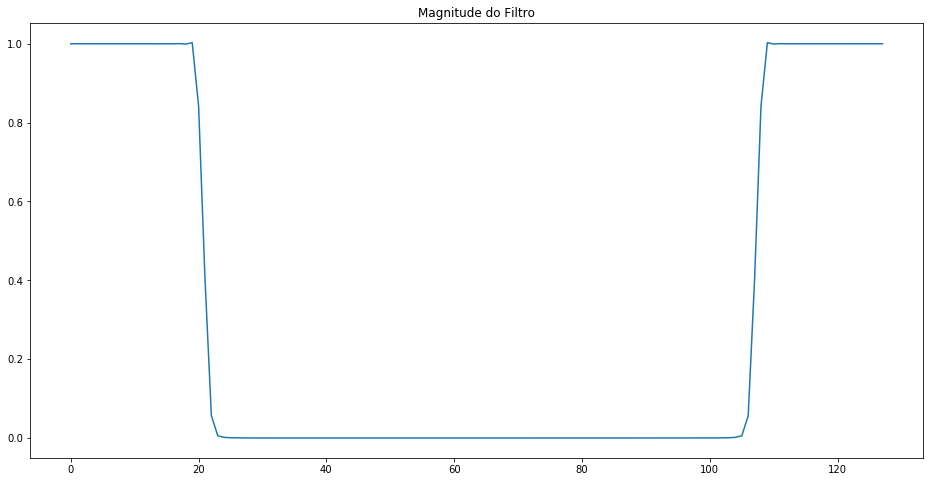

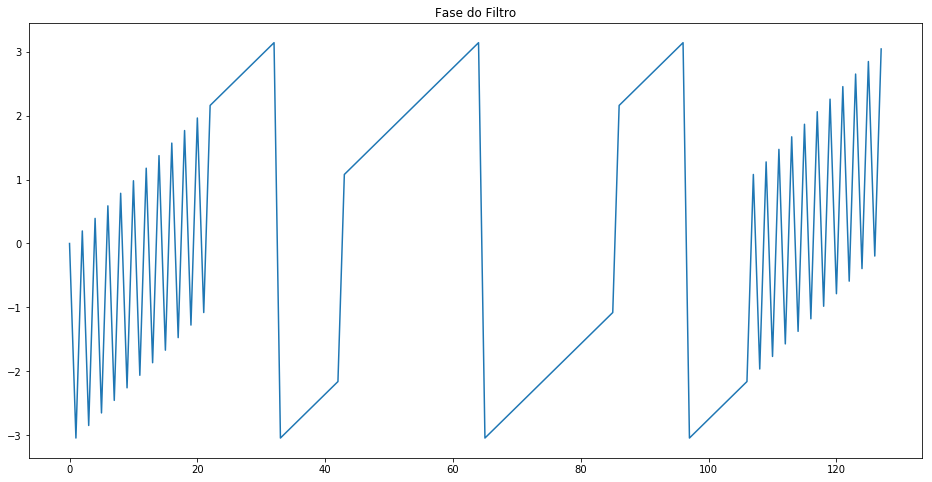

In [39]:
h = complete_zeros(calcular_numero_de_zeros(h), h)
h_jw = fft(1, len(h),h)
plot(np.absolute(h_jw), "Magnitude do Filtro")
plot(np.angle(h_jw), "Fase do Filtro")

## Importação dos arquivos de áudio

In [18]:
fs, data_rute = wavfile.read('voz_de_rute.wav')
fs, data_ruido = wavfile.read('ruido.wav')

## Áudio original

In [19]:
ipd.Audio(data_rute, rate=8000)

## Ruído

In [20]:
ipd.Audio(data_ruido, rate=8000)

## Sinal de voz com adição do ruído

In [21]:
voz_com_ruido = data_rute+0.1*data_ruido
ipd.Audio(voz_com_ruido, rate=8000)

## Voz filtrada utilizando o método de Sobreposição e soma

In [22]:
voz_filtrada_over_and_add = overlap_add(512, voz_com_ruido, h)

In [26]:
ipd.Audio(np.real(voz_filtrada_over_and_add), rate=8000)

## Voz filtrada utilizando o método de Sobreposição e armazenamento

In [24]:
voz_filtrada_over_and_save = overlap_save(512, voz_com_ruido, h)

In [28]:
ipd.Audio(np.real(voz_filtrada_over_and_save), rate=8000)